In [1]:
!pip install torch

In [0]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([transforms.Resize((32, 32)), 
                                                        transforms.RandomHorizontalFlip(), #data augmentation
                                                        transforms.RandomRotation(10), #data augmentation
                                                        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), #data augmentation
                                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #data augmentation
                                                        transforms.ToTensor(), 
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #mean, std

transform = transforms.Compose([transforms.Resize((32, 32)), 
                                                        transforms.ToTensor(), 
                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #mean, std

training_dataset = datasets.CIFAR10(root='/data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='/data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  """可視化用の関数"""
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

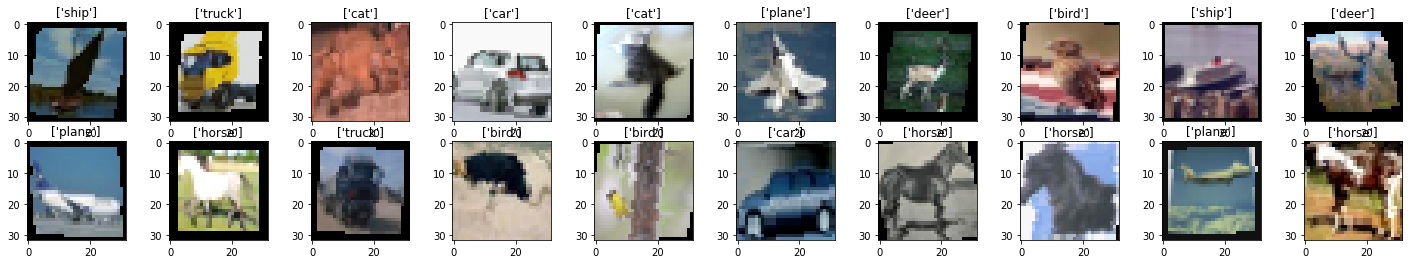

In [7]:
dataiter = iter(training_loader) #iterableなtrain_loader
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([classes[labels[idx].item()]])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) #(input_channel, output_channel, kernel_size, stride)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) #(input_dim, output_dim, kernel_size, stride)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1) #(input_dim, output_dim, kernel_size, stride)
    self.linear1 = nn.Linear(64* 4*4, 500)
    self.dropout = nn.Dropout(0.5)
    self.linear2 = nn.Linear(500, 10)
    
  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv3(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 4*4*64)
    X = F.relu(self.linear1(X))
    X = self.dropout(X)
    X = self.linear2(X)
    return X

In [13]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7057, acc 37.5900 
validation loss: 1.4343, validation acc 47.2400 
epoch : 2
training loss: 1.4117, acc 48.9500 
validation loss: 1.2500, validation acc 55.3700 
epoch : 3
training loss: 1.2700, acc 54.5480 
validation loss: 1.1382, validation acc 59.3200 
epoch : 4
training loss: 1.1789, acc 58.0960 
validation loss: 1.0528, validation acc 62.8100 
epoch : 5
training loss: 1.1161, acc 60.3300 
validation loss: 1.0110, validation acc 64.2300 
epoch : 6
training loss: 1.0549, acc 63.0100 
validation loss: 0.9452, validation acc 67.0200 
epoch : 7
training loss: 1.0239, acc 63.9260 
validation loss: 0.9158, validation acc 67.7200 
epoch : 8
training loss: 0.9954, acc 64.9780 
validation loss: 0.8902, validation acc 68.9500 
epoch : 9
training loss: 0.9586, acc 66.4420 
validation loss: 0.8991, validation acc 68.5800 
epoch : 10
training loss: 0.9390, acc 67.0440 
validation loss: 0.8621, validation acc 70.0300 
epoch : 11
training loss: 0.9190, acc 67.7900 
va

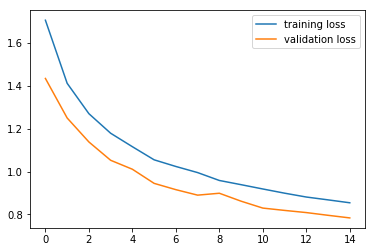

In [16]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

In [0]:
plt.plot(running_corrects_history, label="train accuracy")
plt.plot(val_running_corrects_history, label="val accuracy")